In [6]:
!python /diabetes_detection/src/filters/filterCombined.py

Processed data has been saved to /diabetes_detection/datasets/new.csv.


   Target  Insulin Levels  Age  BMI  Cholesterol Levels  Blood Glucose Levels  \
0       0              27   36   24                 185                   105   
1       1               8    7   16                 151                   121   
2       2              29   30   31                 237                   186   
3       1               8   29   23                 195                   114   
4       0              22   59   28                 191                   113   

   Pancreatic Health  Digestive Enzyme Levels  
0                 56                       55  
1                 49                       60  
2                 62                       96  
3                 67                       60  
4                 63                       76  


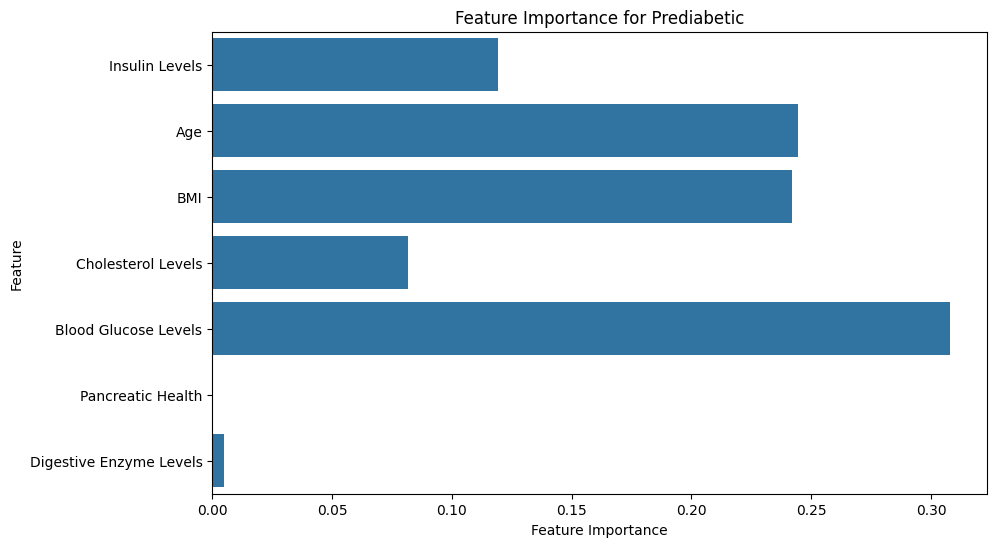

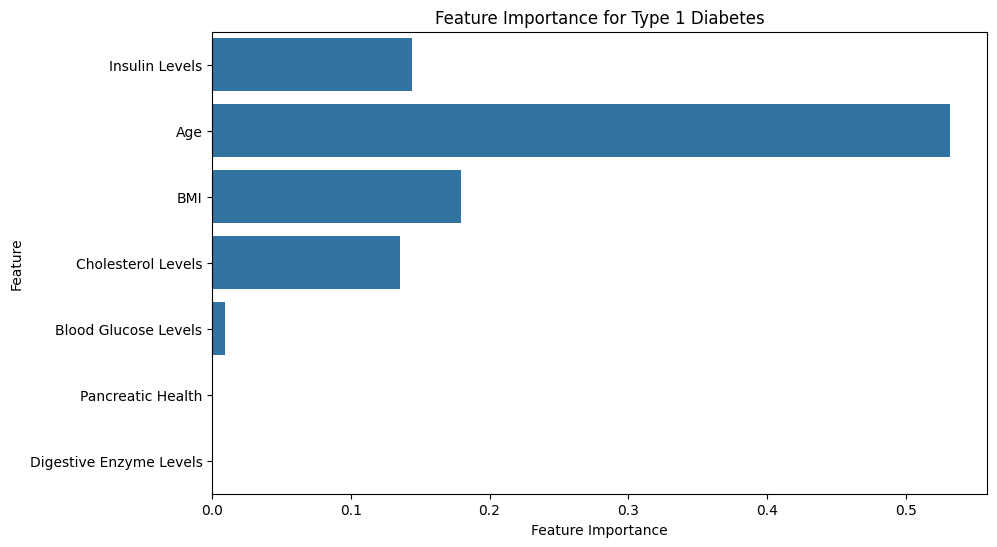

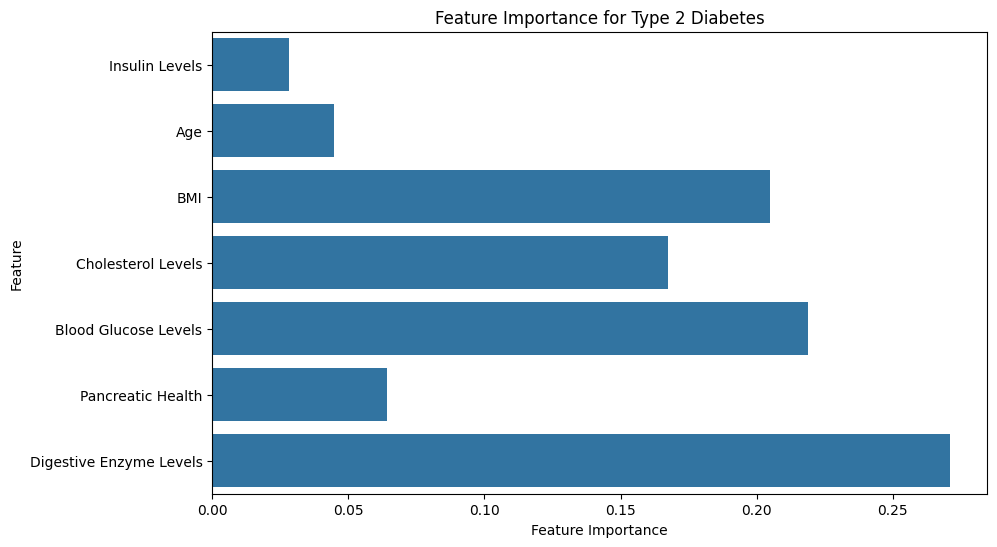

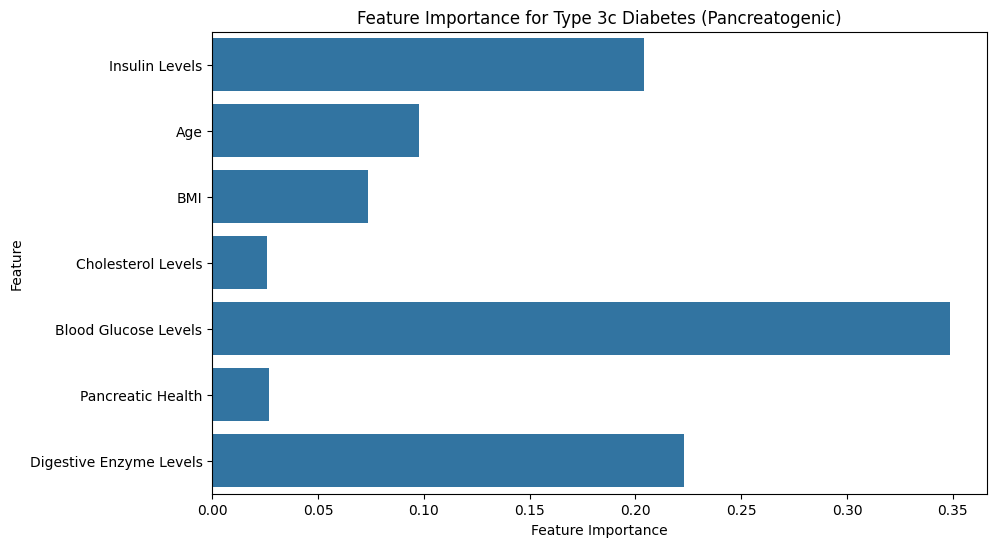

Results for Class 0 (Diabetes Type 0):
[[4368 2135]
 [2113    0]]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      6503
           1       0.00      0.00      0.00      2113

    accuracy                           0.51      8616
   macro avg       0.34      0.34      0.34      8616
weighted avg       0.51      0.51      0.51      8616

Results for Class 1 (Diabetes Type 1):
[[4294 2209]
 [2113    0]]
              precision    recall  f1-score   support

           0       0.67      0.66      0.67      6503
           1       0.00      0.00      0.00      2113

    accuracy                           0.50      8616
   macro avg       0.34      0.33      0.33      8616
weighted avg       0.51      0.50      0.50      8616

Results for Class 2 (Diabetes Type 2):
[[4537 1966]
 [1974  139]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      6503
           1       0.07      0.07      

C:\Users\My PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:06:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\My PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:06:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\My PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:06:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are no

Cross-validation scores: [0.97146163 0.97261859 0.96721944 0.96683378 0.97646605]
Mean CV Accuracy: 0.9709198971114062


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load the data
data_path = '/diabetes_detection/datasets/new.csv'  # Replace with your new file path
data = pd.read_csv(data_path)

# Check the first few rows and columns
print(data.head())

# Feature-target separation
X = data.drop(columns=['Target'])  # Drop the target column
y = data['Target']  # The target column represents the diabetes type (e.g., 0, 1, 2, 3)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_train['Pancreatic Health'] = 10 + X_train['Pancreatic Health'] * 3
X_test['Pancreatic Health'] = 10 + X_test['Pancreatic Health'] * 3

X_train['Insulin Levels'] = X_train['Insulin Levels'] * 2
X_test['Insulin Levels'] = X_test['Insulin Levels'] * 2

# Apply SMOTE to balance the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define hyperparameters for XGBoost
xgb_params = {
    'n_estimators': 96,           # Number of trees
    'max_depth': 6,               # Maximum depth of trees
    'min_child_weight': 100,      # Minimum sum of weights of child nodes
    'subsample': 0.8,             # Fraction of samples used
    'colsample_bytree': 0.8,      # Fraction of features used per tree
    'learning_rate': 0.1,         # Learning rate
    'scale_pos_weight': 1,        # Balance positive/negative classes
    'eval_metric': 'mlogloss',    # Use multi-class log loss
    'random_state': 42            # Reproducibility
}

# Train XGBoost classifiers for each class (One-vs-Rest approach)
classifiers = {}
feature_importances = {}

# Train a classifier for each diabetes type (0, 1, 2, 3)
for class_label in [0, 1, 2, 3]:
    # Create a binary target where the current class is 1 and others are 0
    y_train_bin = (y_train_res == class_label).astype(int)
    y_test_bin = (y_test == class_label).astype(int)
    
    # Initialize XGBoost classifier for current class
    xgb = XGBClassifier(**xgb_params)
    
    # Train the model
    xgb.fit(X_train_res, y_train_bin)
    
    # Store the model
    classifiers[class_label] = xgb
    
    # Store the feature importance for this class
    feature_importances[class_label] = xgb.feature_importances_

# Plot feature importance for each class
class_name = ['Prediabetic', 'Type 1 Diabetes' , 'Type 2 Diabetes' , 'Type 3c Diabetes (Pancreatogenic)']
for class_label in [0,1,2,3]:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances[class_label], y=X.columns)
    plt.title(f"Feature Importance for {class_name[class_label]}")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.show()

# Evaluate the classifiers
for class_label in [0, 1, 2, 3]:
    y_pred_bin = classifiers[class_label].predict(X_test)
    print(f"Results for Class {class_label} (Diabetes Type {class_label}):")
    print(confusion_matrix(y_test_bin, y_pred_bin))
    print(classification_report(y_test_bin, y_pred_bin))

# Cross-validation (optional for model validation)
cv_scores = cross_val_score(xgb, X_train_res, y_train_res, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data_path = '/diabetes_detection/datasets/new.csv'  # Replace with your file path
data = pd.read_csv(data_path)

# Encode categorical features
# categorical_features = ['Cystic Fibrosis Diagnosis', 'Autoantibodies']
# label_encoders = {}

# for col in categorical_features:
#     le = LabelEncoder()
#     data[col] = le.fit_transform(data[col])
#     label_encoders[col] = le  # Save encoder for potential inverse transforms
#     print(f"Encoded '{col}':", dict(zip(le.classes_, le.transform(le.classes_))))
# Feature-target separation
X = data.drop(columns=['Target'])
y = data['Target']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Define a Bayesian Random Forest (using a base RandomForestClassifier for simplicity)
rf = RandomForestClassifier(max_leaf_nodes=25, random_state=69)

# Perform GridSearchCV to find optimal parameters
param_grid = {
    'n_estimators': [96],
    'max_depth': [6],
    'min_samples_split': [100],
    'min_samples_leaf': [80],
    'bootstrap' : [True],
    'max_features' : ['sqrt'],
    'criterion' : ['entropy'],
#   'ccp_alpha': [0.2]
    'class_weight': ['balanced_subsample']
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           #funnel plot
                           scoring='recall', cv=8, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Perform cost-complexity pruning
importances = best_rf.feature_importances_
important_features = np.argsort(importances)[-len(importances)//2:]
X_train_pruned = X_train #.iloc[:, important_features]
X_test_pruned = X_test #.iloc[:, important_features]

# Cross-validation to check for overfitting
cv_scores = cross_val_score(best_rf, X_train_pruned, y_train, cv=12, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# Fit pruned model
best_rf.fit(X_train_pruned, y_train)

# Predictions and confusion matrix
y_pred = best_rf.predict(X_test_pruned)
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
cmd.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Plot a single random tree from the forest
random_tree = np.random.choice(best_rf.estimators_)
plt.figure(figsize=(20, 10))
plot_tree(random_tree, feature_names=X_train_pruned.columns, class_names=best_rf.classes_.astype(str), filled=True)
plt.title("Random Tree from the Random Forest")
plt.show()

# Funnel plots
# Parameters for type 2 and type 3 distinguish
#! Brain insulin resistance and neurotoxins

# Extract tree depths and corresponding scores
tree_depths = [estimator.tree_.max_depth for estimator in best_rf.estimators_]
tree_scores = [estimator.score(X_test_pruned, y_test) for estimator in best_rf.estimators_]

# Create a DataFrame for visualization
tree_stats = pd.DataFrame({'Tree Depth': tree_depths, 'Score': tree_scores})

# Funnel plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tree Depth', y='Score', data=tree_stats, alpha=0.7, color='blue')
sns.lineplot(x='Tree Depth', y='Score', data=tree_stats, color='orange', label='Trend')
plt.title("Funnel Plot of Tree Depth vs. Score")
plt.xlabel("Tree Depth")
plt.ylabel("Score")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# ======================== DIAGNOSTIC PROGRAM ===============================================






In [18]:
import numpy as np
import numba
import shap

print("NumPy version:", np.__version__)
print("Numba version:", numba.__version__)
print("SHAP version:", shap.__version__)

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.

Mean Accuracy: 97.91%


C:\Users\My PC\AppData\Local\Temp\ipykernel_18816\3195037846.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


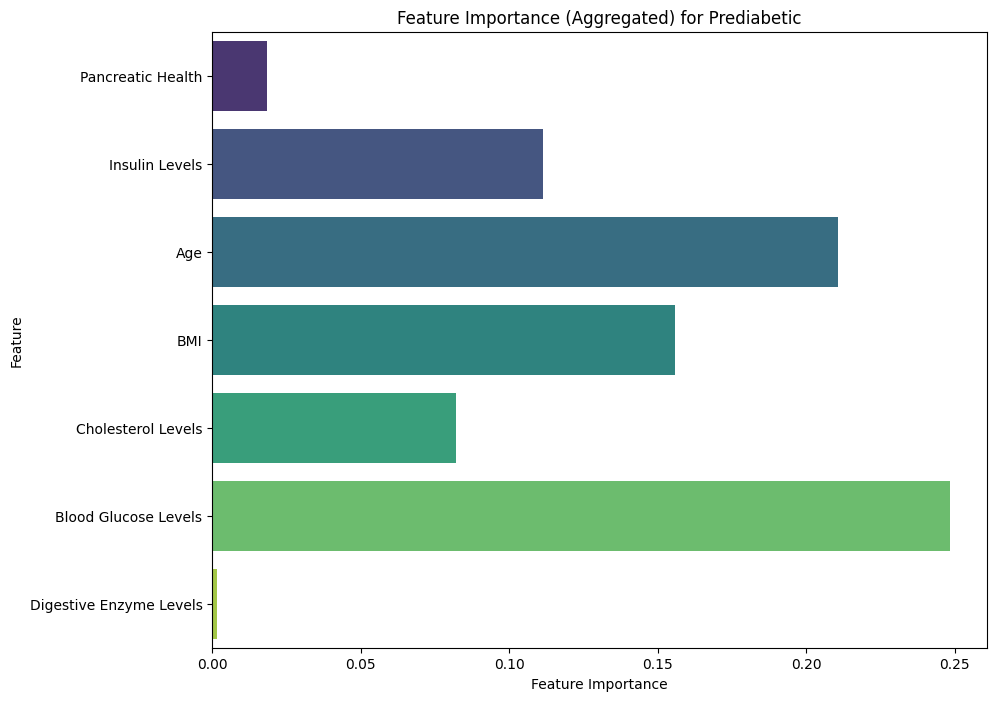

C:\Users\My PC\AppData\Local\Temp\ipykernel_18816\3195037846.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


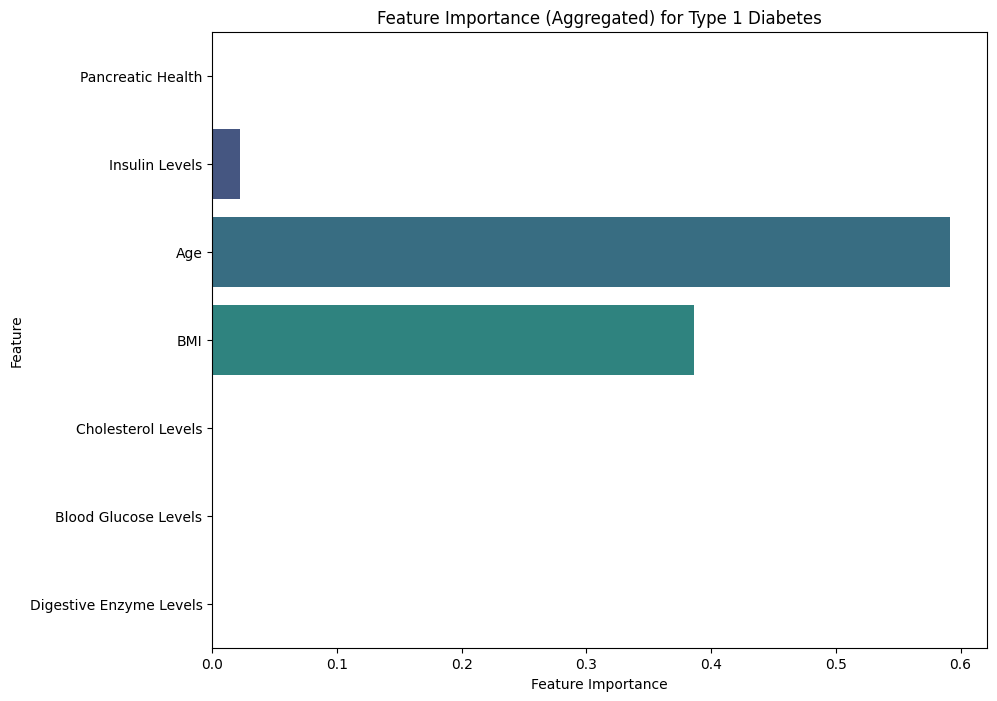

C:\Users\My PC\AppData\Local\Temp\ipykernel_18816\3195037846.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


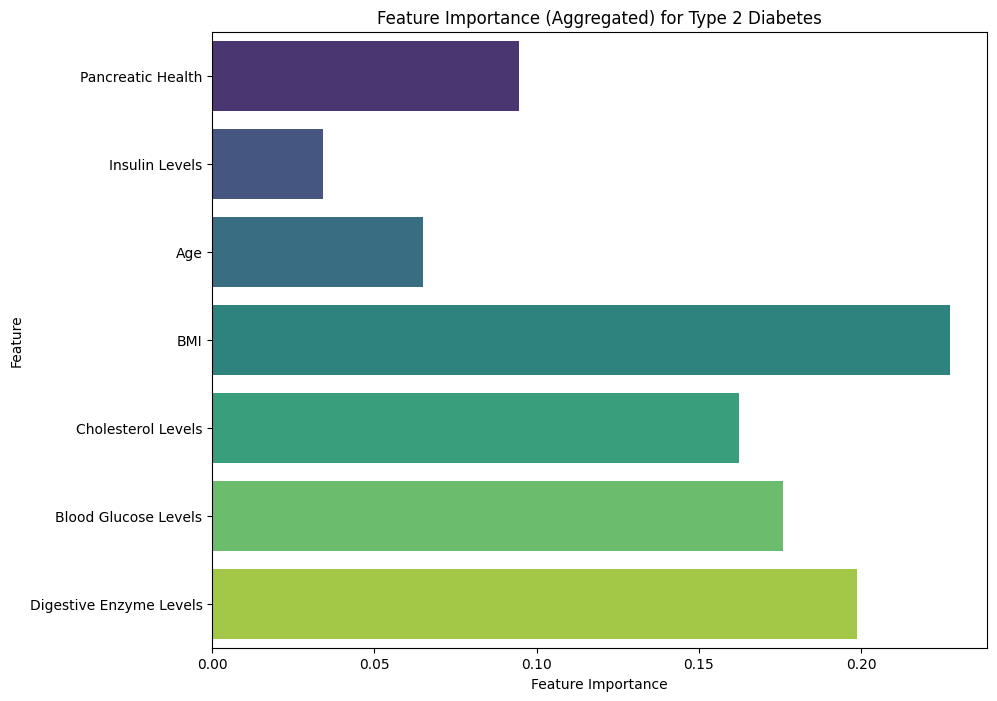

C:\Users\My PC\AppData\Local\Temp\ipykernel_18816\3195037846.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


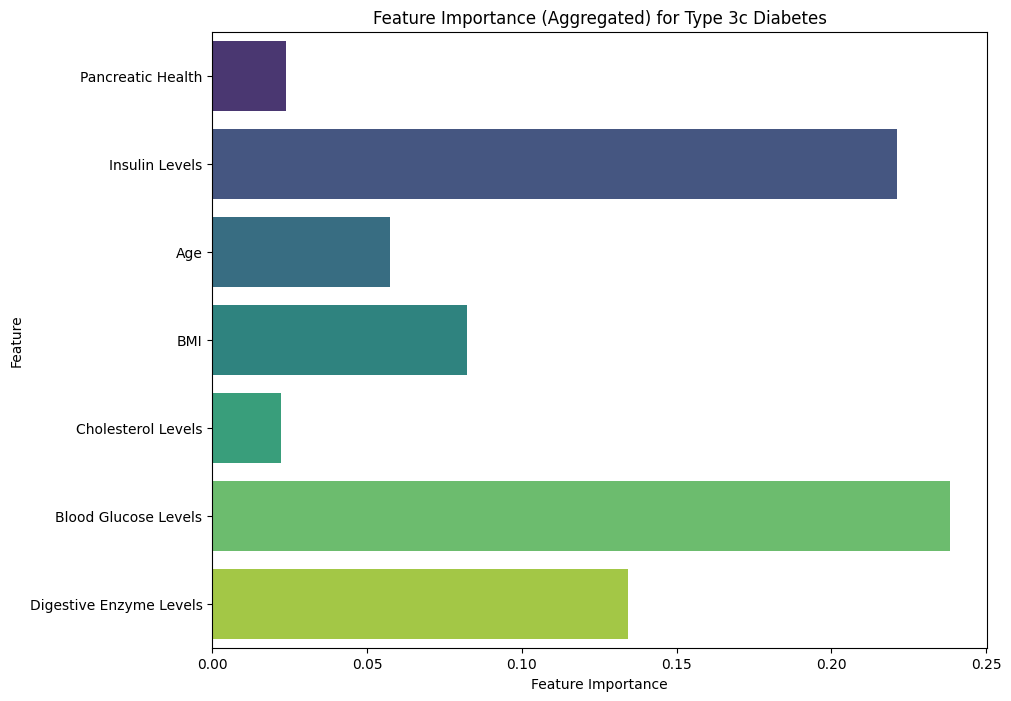

C:\Users\My PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:58:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluating the combined multiclass model...


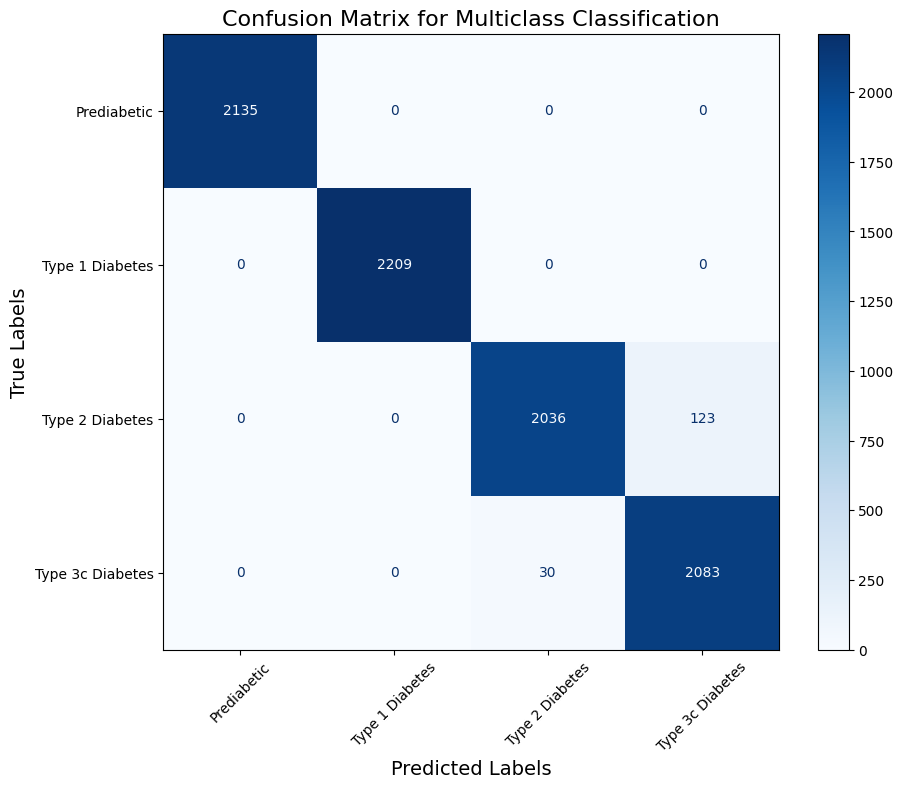

Classification Report:
                  precision    recall  f1-score   support

     Prediabetic       1.00      1.00      1.00      2135
 Type 1 Diabetes       1.00      1.00      1.00      2209
 Type 2 Diabetes       0.99      0.94      0.96      2159
Type 3c Diabetes       0.94      0.99      0.96      2113

        accuracy                           0.98      8616
       macro avg       0.98      0.98      0.98      8616
    weighted avg       0.98      0.98      0.98      8616



In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Load the data
data_path = '/diabetes_detection/datasets/new.csv'  # Replace with your new file path
data = pd.read_csv(data_path)

# Feature-target separation
X = data.drop(columns=['Target'])  # Drop the target column
y = data['Target']  # The target column represents the diabetes type (e.g., 0, 1, 2, 3)

# Feature engineering to enhance specific attributes
X['Pancreatic_Health_Squared'] = X['Pancreatic Health'] ** 2
X['Insulin_Levels_Squared'] = X['Insulin Levels'] ** 2
X['Pancreatic_Health_Insulin_Ratio'] = X['Pancreatic Health'] / (X['Insulin Levels'] + 1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Scale "Pancreatic Health" and "Insulin Levels" more aggressively
X_train['Pancreatic Health'] = 20 + X_train['Pancreatic Health'] * 5
X_test['Pancreatic Health'] = 20 + X_test['Pancreatic Health'] * 5

X_train['Insulin Levels'] = X_train['Insulin Levels'] * 4
X_test['Insulin Levels'] = X_test['Insulin Levels'] * 4

# Apply SMOTE to balance the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define hyperparameters for XGBoost
xgb_params = {
    'n_estimators': 96,           # Number of trees
    'max_depth': 6,               # Maximum depth of trees
    'min_child_weight': 50,       # Lower to encourage feature splitting
    'subsample': 0.8,             # Fraction of samples used
    'colsample_bytree': 0.8,      # Fraction of features used per tree
    'learning_rate': 0.1,         # Learning rate
    'scale_pos_weight': 1,        # Balance positive/negative classes
    'eval_metric': 'mlogloss',    # Use multi-class log loss
    'random_state': 42            # Reproducibility
}

mean_accuracy_percentage = np.mean(cv_scores) * 100
print(f"Mean Accuracy: {mean_accuracy_percentage:.2f}%")


# Feature Importance (combine contributions from engineered features)
feature_importances_by_type_aggregated = {}

for diabetes_type in feature_importances_by_type:
    # Get raw feature importances
    raw_importances = feature_importances_by_type[diabetes_type]
    
    # Map feature names to their indices
    feature_names = X_train.columns
    
    # Aggregate feature importance for "Pancreatic Health" and "Insulin Levels"
    aggregated_importances = {
        'Pancreatic Health': (
            raw_importances[feature_names.get_loc('Pancreatic Health')] +
            raw_importances[feature_names.get_loc('Pancreatic_Health_Squared')] +
            raw_importances[feature_names.get_loc('Pancreatic_Health_Insulin_Ratio')]
        ),
        'Insulin Levels': (
            raw_importances[feature_names.get_loc('Insulin Levels')] +
            raw_importances[feature_names.get_loc('Insulin_Levels_Squared')]
        )
    }
    
    # Include other attributes directly (excluding engineered features)
    for feature in feature_names:
        if feature not in ['Pancreatic_Health_Squared', 'Insulin_Levels_Squared', 'Pancreatic_Health_Insulin_Ratio']:
            aggregated_importances[feature] = raw_importances[feature_names.get_loc(feature)]
    
    # Store aggregated importance for this diabetes type
    feature_importances_by_type_aggregated[diabetes_type] = aggregated_importances

# Plot feature importance for each diabetes type (aggregated)
for diabetes_type, importances in feature_importances_by_type_aggregated.items():
    plt.figure(figsize=(10, 8))
    sns.barplot(
        x=list(importances.values()), 
        y=list(importances.keys()), 
        palette="viridis"
    )
    plt.title(f"Feature Importance (Aggregated) for {class_names[diabetes_type]}")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.show()


# Multiclass Confusion Matrix and Evaluation
print("Evaluating the combined multiclass model...")
final_model = XGBClassifier(**xgb_params)
final_model.fit(X_train_res, y_train_res)
y_pred = final_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Create a display for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot with adjusted figure size and font size
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)  # Rotate x-axis labels for better readability
plt.title("Confusion Matrix for Multiclass Classification", fontsize=16)  # Increase title font size
plt.xlabel("Predicted Labels", fontsize=14)  # Increase font size for x-axis label
plt.ylabel("True Labels", fontsize=14)  # Increase font size for y-axis label
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))
